<a href="https://colab.research.google.com/github/jgamel/learn_n_dev/blob/python_programming/multithread_vs_multiprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multithreading vs. Multiprocessing in Python

The differences between the two, and how and when to use them

Python is often regarded as an almost obscene programming language. A libertarian place where everything is permitted and our wildest dreams come true. Forget about labels and definitions, and, above all, brackets. It is a language that welcomes everyone, from the most experienced programmer (that weird guy that still uses Fortran for some reason you don’t really want to know about) to the egotistic millennial newbie. Well, that is, except if you are working with multiprocessing or multithreading.

The challenges of working with parallelism and concurrency in Python begins with the fact that even the internet does not understand very well how it works. Indeed, I’ve found multiple wrong statements on stackoverflow responses (some with a high count of up votes) and even very serious-looking blogs. Therefore, differently from other cases, where programming may also be called stackoverflowing, you better know at least the basics of what you are doing before starting to work with multiprocessing or multithreading in Python.

Or else, you might have a bad time.

## The Basics

When looking for the difference between python multiprocessing and multithreading, one might have the impression that they work pretty much the same. That could not be more wrong. The key differences are:

* A process is an independent instance executed in a processor core. Threads are components of a process and run concurrently (inside that process).
* Processes do not share the same memory space, while threads do (their mother’s memory, poetic, right?).
* Threads are lighter and cause less overhead. Also, because they share the same memory inside a process, it is easier, faster, and safer to share data.
* True parallelism can ONLY be achieved using multiprocessing. That is because only one thread can be executed at a given time inside a process time-space. This is assured by [Python’s global interpreter lock (GIL)](https://github.com/jgamel/learn_n_dev/blob/python_programming/python_multi_tutorial.ipynb).
* Processes execution is scheduled by the operating system, while threads are scheduled by the GIL.

We should also understand the difference between concurrency and parallelism.

**Concurrent** execution means that two or more tasks are progressing at the same time.

**Parallel** execution implies that two or more jobs are being executed simultaneously.

Now remember: multithreading implements concurrency, multiprocessing implements parallelism. Processes run on separate processing nodes.



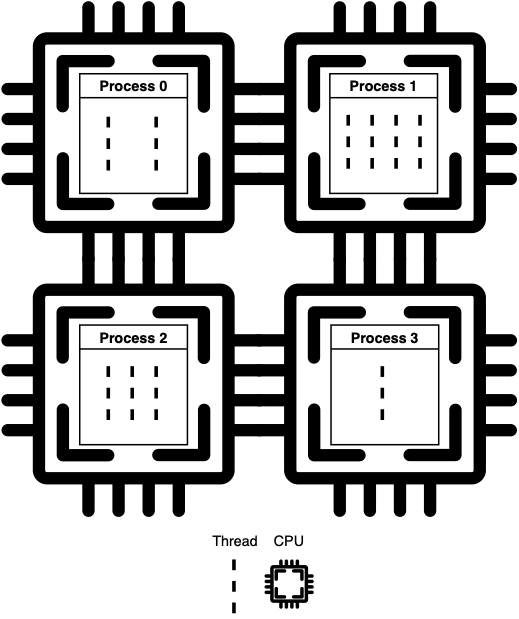

## The Use Cases


So how do we decide between multiprocessing and multithreading? The short answer is:

* Multithreading for I/O intensive tasks and;
* Multiprocessing for CPU intensive tasks (if you have multiple cores available)

But why?

### Multithreading: I/O bound tasks

Imagine you have a task that relies on the input from another part of the system, or from the user.

There is no reason to dedicate a process for that job because it would spend most of its time waiting for the stimuli to begin its work. It would be a waste of resources to dedicate a computing node for that, and it would bring no speedup whatsoever, given that the bottleneck is not on execution but on a third-party call. In this case, multithreading is the way to go.

Indeed, multithreading is usually implemented to handle GUIs. E.g., in a text editor program, one thread would be responsible for getting input from the keyboard, while another would check the spelling, and a third one could handle the formatting configurations.

I/O intensive programs can also directly benefit from multithreading because their bottlenecks are usually reading or writing operations (or downloads in the case of web scrappers, for example). Check the following example:



In [75]:
def io_intensive(x):
    write_count = 50
    with urllib.request.urlopen(addrs[x], timeout=20) as conn:
        page = conn.read()
        for _ in range(write_count):
            with open('output.txt', 'w') as output:
                output.write(str(page))

This function loads some URL addresses into memory and writes them in a local text file (50 times, always overwriting the same file). That is pretty dumb, but its purpose is just to stress an I/O bound execution. 

This presents examples of application of multithreading and multiprocessing in python, their pros and cons, and the most appropriate case scenarios for each:

In [76]:
import math
import time
import urllib.request
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor



addrs = ['http://www.poatek.com',
        'https://www.poatek.com/team/',
        'https://www.poatek.com/blog/',
        'https://www.poatek.com/our-method/',
        'https://www.poatek.com/services/',
        'https://en.wikipedia.org/wiki/Main_Page',
        'https://www.google.com/',
        'https://www.kaggle.com/competitions',
        'https://www.amazon.com/charts/mostread/fiction/',
        'https://www.amazon.com/charts/mostread/nonfiction',
        'https://www.amazon.com/charts/mostsold/nonfiction',
        'https://www.amazon.com/charts/mostsold/fiction',
        'https://www.nytimes.com',
        'https://www.bbc.com/',
        'https://www.lemonde.fr',
        'https://edition.cnn.com',
        ]

In [77]:
def multithreading(func, args, workers):
    with ThreadPoolExecutor(workers) as ex:
        res = ex.map(func, args)
    return list(res)


def multiprocessing(func, args, workers):
    with ProcessPoolExecutor(workers) as ex:
        res = ex.map(func, args)
    return list(res)

### Multithreading: I/O intensive tasks

I/O intensive programs can directly benefit from multithreading because their bottlenecks are usually reading and/or writing operations (or downloads in the case of web scrappers, for example).

In this example we will test a function that reads webpages and writes them on a local text file (we forced the file to be re-written a number of times to stress the execution).

In [78]:
def io_intensive(x):
    write_count = 50
    with urllib.request.urlopen(addrs[x], timeout=20) as conn:
        page = conn.read()
        for _ in range(write_count):
            with open('output.txt', 'w') as output:
                output.write(str(page))

def test_io_intensive_threads(thread_count_lst):
    times = []
    num_tasks = len(addrs)
    time_init = time.time()
    for i in range(num_tasks): 
        io_intensive(i)
    time_end = time.time()
    times.append(float(time_end - time_init))
    print(f'Serial execution took {time_end - time_init}s.')
    for n_threads in thread_count_lst:
        time_init = time.time()
        multithreading(io_intensive, range(num_tasks), n_threads)
        time_end = time.time()
        times.append(float(time_end - time_init))
        print(f'Multithreading with {n_threads} threads took {time_end - time_init}s.')
    return times

Serial execution took 18.81404948234558s.
Multithreading with 2 threads took 9.829651832580566s.
Multithreading with 4 threads took 6.756406545639038s.
Multithreading with 8 threads took 4.45278000831604s.
Multithreading with 16 threads took 3.508880853652954s.


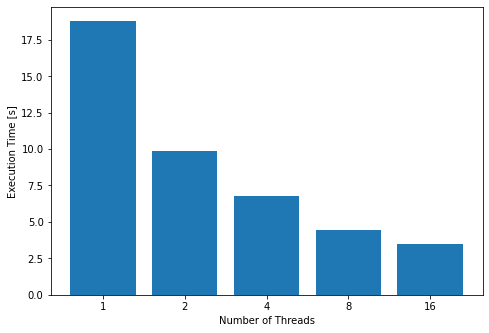

In [79]:
times = test_io_intensive_threads([2, 4, 8, 16])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel('Number of Threads')
ax.set_ylabel('Execution Time [s]')
num_threads = ['1', '2', '4', '8', '16']
ax.bar(num_threads, times)
plt.show()

Should notice that we were able to reduce considerably the execution time of that code.

### Multiprocessing: CPU-intensive tasks (MacOS and Linux)

Programs that are CPU-bound will benefit from multiprocessing because their bottleneck is time and resources. Image and graphics processing are good examples, as they consist of huge amounts of math operations, that can often be divided into separate tasks because their data is independent. GPUs are the state-of-the-art hardware on this regard, being designed to process large chunks of data in parallel.

If you try to execute this code on windows, you will probably run into the following error: BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending. 

In [80]:
def compute_intensive(x):
    foo = 0
    for i in range(10**7):
        foo += foo * math.cos(i*math.pi)
        
def test_compute_intensive():
    times = []
    num_tasks = 4
    time_init = time.time()
    for i in range(num_tasks): 
        compute_intensive(i)
    time_end = time.time()
    times.append(float(time_end - time_init))
    print(f'Serial execution took {time_end - time_init}s.')
    n_threads = num_tasks
    time_init = time.time()
    multithreading(compute_intensive, range(num_tasks), n_threads)
    time_end = time.time()
    times.append(float(time_end - time_init))
    print(f'Multithreading with {n_threads} threads took {time_end - time_init}s.')
    n_procs = num_tasks
    time_init = time.time()
    multiprocessing(compute_intensive, range(num_tasks), n_procs)
    time_end = time.time()
    times.append(float(time_end - time_init))
    print(f'Multiprocessing with {n_procs} processes took {time_end - time_init}s.')
    return times


Serial execution took 10.498757123947144s.
Multithreading with 4 threads took 10.659828901290894s.
Multiprocessing with 4 processes took 10.830437898635864s.


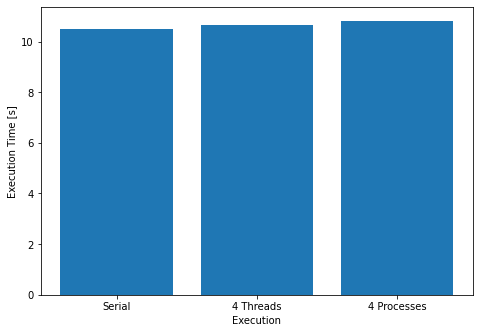

In [81]:
times = test_compute_intensive()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel('Execution')
ax.set_ylabel('Execution Time [s]')
num_threads = ['Serial', '4 Threads', '4 Processes']
ax.bar(num_threads, times)
plt.show()

###Multiprocessing on I/O intensive tasks

We have not tested multiprocessing on I/O intesive functions. Even thougt it is, in theory, a waste of resources to dedicate a process to a I/O-bound task, there should be no reason for multiprocessing to be unable to achieve speedups in this use case.

Let's check it out:

In [84]:
def test_io_intensive_processes(proc_count_lst):
    times = []
    num_tasks = len(addrs)
    time_init = time.time()
    for i in range(num_tasks): 
        io_intensive(i)
    time_end = time.time()
    times.append(float(time_end - time_init))
    print(f'Serial execution took {time_end - time_init}s.')
    for n_procs in proc_count_lst:
        time_init = time.time()
        multiprocessing(io_intensive, range(num_tasks), n_procs)
        time_end = time.time()
        times.append(float(time_end - time_init))
        print(f'Multiprocessing with {n_procs} processes took {time_end - time_init}s.')
    return times

Serial execution took 17.963932991027832s.
Multiprocessing with 2 processes took 9.799303770065308s.
Multiprocessing with 4 processes took 6.658160448074341s.
Multiprocessing with 8 processes took 5.368286609649658s.


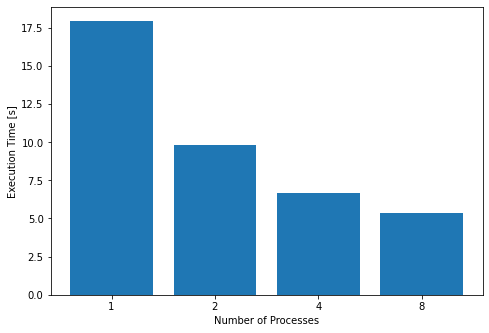

In [85]:
times = test_io_intensive_processes([2, 4, 8])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel('Number of Processes')
ax.set_ylabel('Execution Time [s]')
num_threads = ['1', '2', '4', '8']
ax.bar(num_threads, times)
plt.show()

As expected, multiprocessing could also deliver speedup for an IO-bound task. You may however notice that threads are still the best option for that case. That is because proccesses have a much higher initialization cost that may compromise their performance. Also, as discussed before, the number of process you can have execution in parallel is limited by the number of processing cores of the machine you are using.

###Multiprocessing: CPU bound tasks

Now imagine you got a massive amount of data loaded in memory, and it all needs to be processed. Programs that are computing-bound will benefit from multiprocessing because their bottleneck is time and resources. Image and graphics processing are an excellent example of that. They consist of vast amounts of math operations, which can often be divided into separate tasks because their data is independent. GPUs are the state-of-the-art hardware in this regard, being designed to process large chunks of data in parallel.

To simulate computing-intensive algorithm, we will use the following code:

In [86]:
def compute_intensive(x):
    foo = 0
    for i in range(10**7):
        foo += foo * math.cos(i*math.pi)

### Multiprocessing on I/O intensive tasks

Even though this is not their best use case, there is no reason to expect multiprocessing to perform poorly on I/O intensive tasks. It is a waste of resources: imagine dedicating a processor core to a function that will, for a significant part of its execution, just wait for an input. A processor, even a cluster, only has so many processing nodes. We are better off dedicating them to real parallelism of applications that can only be accelerated by those means.

## A Data Science Example

Now, let’s take a deeper look on how we can implement multiprocessing and multithreading in Python and how a Data Scientist can profit from them. There are many different ways to do it:

1. [Cuncurrent Futures](https://docs.python.org/3/library/concurrent.futures.html)
2. [Thread-based Parallelism](https://docs.python.org/3.8/library/threading.html) 
3. [Process-based Parallelism](https://docs.python.org/3.8/library/multiprocessing.html)

In a very broad aspect, a data science project follows four steps:

1. Get the data;
2. Process the data;
3. Do something with the data;
4. Store other data

Now, it should not be hard to follow that the “get the data” and “store other data” steps are probably the ones where we should use multithreading. All the others (“process the data” and “do something with the data”) are most probably better off using multiprocessing. You may argue that processing a lot of data might present an I/O bottleneck, and in some cases you might be right. If that is your case, you should try to break up this processing into “getting data” and “processing data” parts, so that the best strategy can be applied to each of them. 

### Text Classification

Let’s see how we can apply what we’ve learned in a classic Natural Language Processing (NLP) problem: text classification. The idea is to find out the category of a news article just by its text (e.g.: if it should be categorised as “sports”, “finances”, “economy”, etc).

Our project is quite simple, we will:

1. Get some data from Reuters News Agency containing news and their respective labels (defining what type of news they are) (Data source);
2. Vectorize them using GloVe pre-trained word vectors (trained from Wikipedia) (GloVe project page);
3. Train a model using Random Forests with scikit-learn to classify texts under the given labels.

By now it shall be straightforward to see that step 1 can possibly be accelerated in Python using multithreading, while step 3 should use multiprocessing.




### Loading Data

Let’s start by the pre-trained GloVe word vectors loading. 

Loading this pre-trained word vector file can take a lot of time. The file is considerably long, and we have to process it line per line. Each line contains a word and then a list of values for each dimension of its word vector.


In [87]:
!wget !wget http://nlp.stanford.edu/data/glove.6B.zip -O /tmp/glove.6B.zip

--2022-05-16 20:28:11--  http://!wget/
Resolving !wget (!wget)... failed: Name or service not known.
wget: unable to resolve host address ‘!wget’
--2022-05-16 20:28:11--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-05-16 20:28:11--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-16 20:28:12--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64

In [88]:
!unzip /tmp/glove*.zip

Archive:  /tmp/glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: glove.6B.50d.txt        A

  inflating: glove.6B.100d.txt       AA

  inflating: glove.6B.200d.txt       A

  inflating: glove.6B.300d.txt       A



In [92]:
!ls

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.50d.txt.zip  sample_data
glove.6B.200d.txt  glove.6B.50d.txt   output.txt


In [90]:
!zip -r glove.6B.50d.txt.zip glove.6B.50d.txt

updating: glove.6B.50d.txt (deflated 60%)


In [91]:
!ls

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.50d.txt.zip  sample_data
glove.6B.200d.txt  glove.6B.50d.txt   output.txt


In [93]:
import os
import io
import sys
import time
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor, as_completed, wait
from sklearn.ensemble import RandomForestClassifier

# used for multithread file processing
def process_vector(line, wordVec_dict, embedding, idx2word):
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    wordVec_dict[word] = vec
    embedding.append(vec)
    idx2word.append(word)

class GloveVectorizer:
    def __init__(self, multithread=False, workers=10):
    # load in pre-trained word vectors
    # which is just a space-separated text file in the format:
    # word vec[0] vec[1] vec[2] ...
        print('Loading word vectors...')
        wordVec_dict = {}
        embedding = []
        idx2word = []
    
        time_init = time.time()
        if multithread:
            executor = ThreadPoolExecutor(max_workers=workers)
            futures = []
            with zipfile.ZipFile('glove.6B.50d.txt.zip') as zf:
                with io.TextIOWrapper(zf.open('glove.6B.50d.txt'), encoding='utf-8', errors='ignore') as f:
                    for line in f:
                        futures.append(executor.submit(process_vector, line, wordVec_dict, embedding, idx2word))
            for future in as_completed(futures):
                pass
        else:   
            with zipfile.ZipFile('glove.6B.50d.txt.zip') as zf:
                with io.TextIOWrapper(zf.open('glove.6B.50d.txt'), encoding='utf-8', errors='ignore') as f:
                    for line in f:
                        values = line.split()
                        word = values[0]
                        vec = np.asarray(values[1:], dtype='float32')
                        wordVec_dict[word] = vec
                        embedding.append(vec)
                        idx2word.append(word)
            
        time_end = time.time()
        print(f'Found {len(wordVec_dict)} word vectors in {time_end - time_init}s.')

        self.wordVec_dict = wordVec_dict
        self.embedding = np.array(embedding)
        self.word2idx = {v:k for k,v in enumerate(idx2word)}
        self.V, self.D = self.embedding.shape


    def transform(self, data):
        X = np.zeros((len(data), self.D))
        n = 0
        emptycount = 0
        for sentence in data:
            tokens = sentence.lower().split()
            vecs = []
            for word in tokens:
                if word in self.wordVec_dict:
                    vec = self.wordVec_dict[word]
                    vecs.append(vec)
            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[n] = vecs.mean(axis=0)
            else:
                emptycount += 1
            n += 1
        print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
        return X


### Hands-on

We will train a text classificator with scikit-learn using data provided from Reuters. The data consists of news texts classified into 8 different labels.

### GloVe Vectorizing

We will use a pre-trained set of GloVe word vectors.

That's where we can profit from using multithreading. Loading this pre-trained word vector file can take a lot of time. The file is considerably big, and we have to process it line per line. Each line contains a word and then a list of values for each dimension of its word vector.

The GloveVectorizer object loads the pre-trained file. Let's start by creating with no multithreading:

In [94]:
vectorizer = GloveVectorizer()

Loading word vectors...
Found 400000 word vectors in 6.162254333496094s.


Now let's see how much time it takes if we use multithreading (check the __init__ class code if you are interested in how I've implemented it).

In [95]:
vectorizer = GloveVectorizer(multithread=True)

Loading word vectors...
Found 400000 word vectors in 18.901681184768677s.


### Model training and testing

Start by loading the data into dataframes. No need to use multiprocessing nor multithreading here, as reading CSVs into pandas dataframes is stupid fast.

Then we vectorize the train and test data.

In [96]:
train = pd.read_csv('https://raw.githubusercontent.com/jgamel/learn_n_dev/input_data/r8-train-all-terms.txt', header=None, sep='\t')
test = pd.read_csv('https://raw.githubusercontent.com/jgamel/learn_n_dev/input_data/r8-test-all-terms.txt', header=None, sep='\t')
train.columns = ['label', 'content']
test.columns = ['label', 'content']

vectorizer = GloveVectorizer()
Xtrain = vectorizer.transform(train.content)
Ytrain = train.label
Xtest = vectorizer.transform(test.content)
Ytest = test.label

Loading word vectors...
Found 400000 word vectors in 6.036802053451538s.
Numer of samples with no words found: 0 / 5485
Numer of samples with no words found: 0 / 2189


Now the cool part: training and testing.

Luckly for us,scikit-learn offers multiprocessing nativelly, just by setting it up on the model's parameters. The following cell will train a same model with the same data using different number of jobs (jobs are mapped to processes in scikit-learn).

train score: 0.9992707383773929
test score: 0.9337597076290544
Serial training took 7.515476226806641s.
Multiprocessing training with 2 processes took 5.1878602504730225s.
Multiprocessing training with 4 processes took 5.215019941329956s.
Multiprocessing training with 8 processes took 5.222301006317139s.


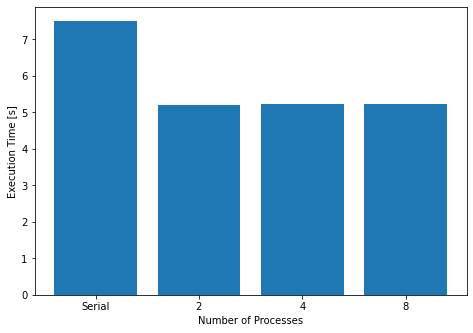

In [97]:
# create the model, train it, print scores
times = []

time_init = time.time()
model = RandomForestClassifier(n_estimators=200)
model.fit(Xtrain, Ytrain)
print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))
time_end = time.time()
times.append(float(time_end - time_init))
print(f'Serial training took {time_end - time_init}s.')

time_init = time.time()
model = RandomForestClassifier(n_estimators=200, n_jobs=2)
model.fit(Xtrain, Ytrain)
time_end = time.time()
times.append(float(time_end - time_init))
print(f'Multiprocessing training with 2 processes took {time_end - time_init}s.')

time_init = time.time()
model = RandomForestClassifier(n_estimators=200, n_jobs=4)
model.fit(Xtrain, Ytrain)
time_end = time.time()
times.append(float(time_end - time_init))
print(f'Multiprocessing training with 4 processes took {time_end - time_init}s.')

time_init = time.time()
model = RandomForestClassifier(n_estimators=200, n_jobs=8)
model.fit(Xtrain, Ytrain)
time_end = time.time()
times.append(float(time_end - time_init))
print(f'Multiprocessing training with 8 processes took {time_end - time_init}s.')

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel('Number of Processes')
ax.set_ylabel('Execution Time [s]')
num_threads = ['Serial', '2', '4', '8']
ax.bar(num_threads, times)
plt.show()

Well, the image and the timing data speaks by itself. Notice how the speedup stagnates once you reach the number of cores your machine has available (or, of course, a natural plateau).